# EELS SrFeO Project 
## RNN Autoencoder

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on RNN Autoencoder

* <span style="color: red"> // put resources here // </span>

### Import Package

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

Using TensorFlow backend.


In [4]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [34]:
# checking device (GPU & CPU)
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5173053241859719537
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13542397428813602607
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10598757172
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17860845222453566759
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:05:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10658401485
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14963678856450958487
physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3725701033409061076
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type

## Load Data

In [94]:
#data = hs.load("processed_data/EELS_raw_*.hdf5")
import pickle
class Container(object): pass
temporal_data = list()
for k in range(48):
    f = pickle.load(open("processed_data/EELS_o_range_"+str(k)+".pkl", 'rb'))
    temporal_data.append(f)

In [95]:
temporal_data[0].O_range.shape

(28, 114, 300)

## Applying RNN Autoencoder to temporal data

In [96]:
temporal_data[0].data.shape

(28, 114, 3710)

### Visualize aggregated signals

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

Text(0, 0.5, 'counts')

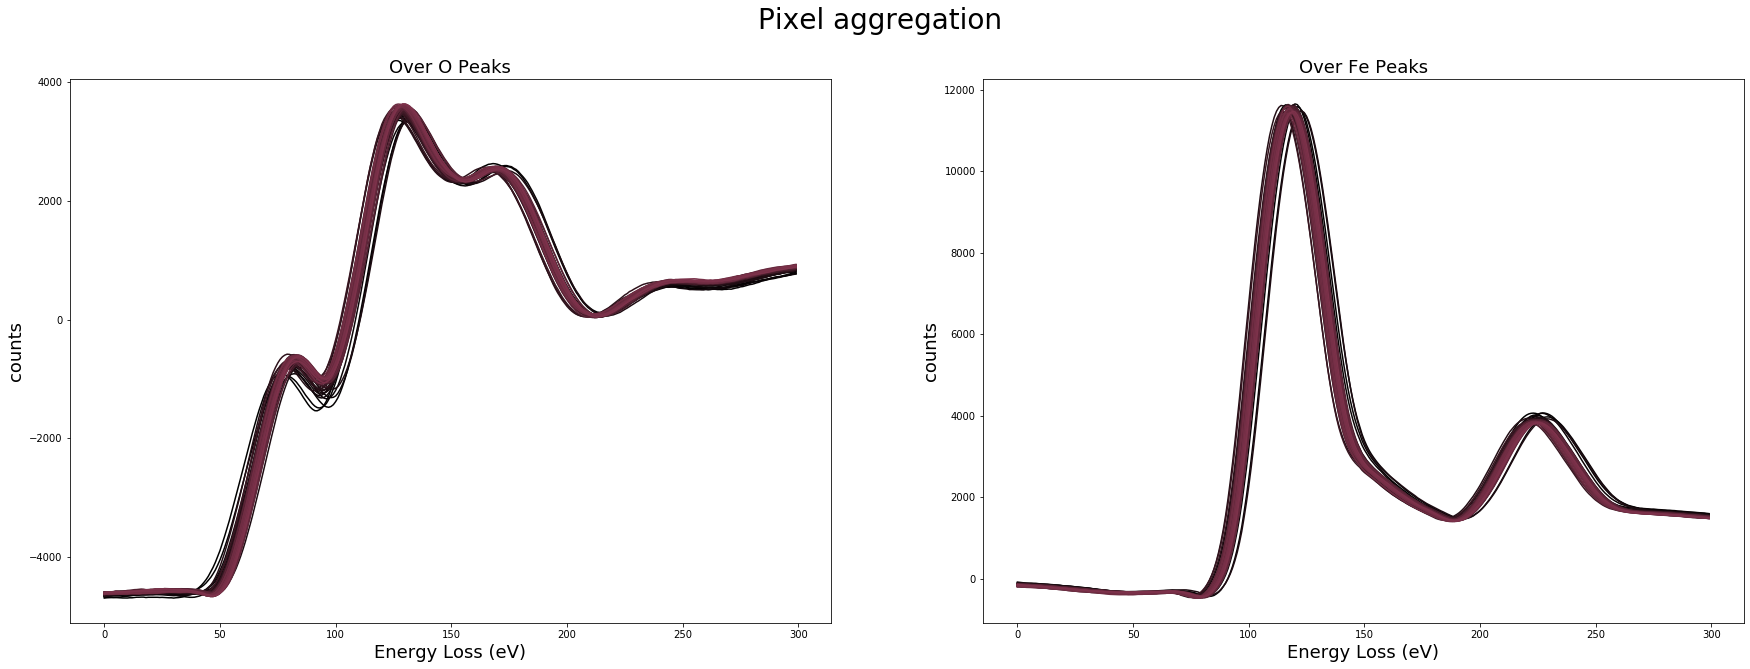

In [70]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV

# Plotting aggregared spectra 
g,(ax3,ax4) = plt.subplots(1,2, figsize=(30,10))
for k in range(len(temporal_data)):
    # Plotting aggregation over oxygen range
    ax3.plot(np.sum(temporal_data[k].O_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))
    # Plotting aggregation over Fe range
    ax4.plot(np.sum(temporal_data[k].Fe_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))

# plot configurations
g.suptitle('Pixel aggregation', fontsize=28)

ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('counts', fontsize=18)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)  

In [98]:
# rearrange dimension
arrayx = list()
dim = temporal_data[0].O_range.shape
for i in range(len(temporal_data)):
    f = temporal_data[i].O_range.reshape((-1,dim[2]))
    arrayx.append(f)
arrayx = np.array(arrayx).reshape((-1,dim[2]))

In [99]:
arrayx.shape

(153216, 300)

### Setting up RNN autoencoder

In [85]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Conv2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [86]:
def rnn_autoencoder(layer, size, N_encode, 
                    N_decode, embed, 
                    N_steps, lr = 3e-6, drop_frac = 0.01,
                    bidir = False, l1_norm = 1e-4, **kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    N_encode  : numpy, int
        sets the number of encoding layers in the network
    N_decode : numpy, int
        sets the number of decoding layers in the network
    embed : numpy, int
        sets the size of the embedding layer
    N_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidir : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    model = Sequential()
    
    # wrapper for bidirectional LSTM
    if bidir: wrapper = Bidirectional
    else: wrapper = lambda x: x
        
        
    # builds the first layer
    model.add(wrapper(layer(size, return_sequences=(N_encode > 1),  dropout=drop_frac, input_shape=(N_steps, 1))))

    # builds the encoding layers
    for i in range(1, N_encode):
        model.add(wrapper(layer(size, return_sequences=(i < N_encode - 1), dropout=drop_frac)))

    # builds the embedding layer
    model.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(N_steps))

    # builds the decoding layer
    for i in range(N_decode):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

In [87]:
def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. 
        It is however limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                 verbose=0, save_best_only=True,
                                                 save_weights_only=True, 
                                                 mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_train), 
              epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], 
              validation_data=(np.atleast_3d(data_test), np.atleast_3d(data_test)))

### Training RNN Autoencoder

In [88]:
# construct a model
model3 = rnn_autoencoder(LSTM, 300, 3, 3, 16, 300)

In [89]:
# set learning rate and compile model
lr = 5e-3
model3.compile(Adam(lr), loss='mse')

In [90]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 300, 300)          362400    
_________________________________________________________________
lstm_10 (LSTM)               (None, 300, 300)          721200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 300)               721200    
_________________________________________________________________
encoding (Dense)             (None, 16)                4816      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 300, 16)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 300, 300)          380400    
_________________________________________________________________
lstm_13 (LSTM)               (None, 300, 300)         

In [ ]:
folder_name = 'rnn_auto_checkpoints'
train_model(model3, arrayx, arrayx, folder_name, epochs=100, batch_size=100)

W1213 17:07:50.534893 140232286345024 deprecation_wrapper.py:119] From /home/pht219/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 153216 samples, validate on 153216 samples
Epoch 1/100
153216/153216 [==============================] - 2085s 14ms/step - loss: 0.3005 - val_loss: 0.2012
Epoch 2/100
153216/153216 [==============================] - 2086s 14ms/step - loss: 0.2055 - val_loss: 0.2071
Epoch 3/100
153216/153216 [==============================] - 2082s 14ms/step - loss: 0.2011 - val_loss: 0.2011
Epoch 4/100
 81900/153216 [===============>..............] - ETA: 12:01 - loss: 0.1996

### <span style="color:blue"> Training may take a few days depending on epochs. </span>
    At this point, just let the training run in the background. 
    Go to the next notebook to analyze the trained results.

In [101]:
test = arrayx[:1000]

In [102]:
predict = model3.predict(np.atleast_3d(test))

In [103]:
predict.shape

(1000, 300, 1)

Text(0.5, 0.98, 'Spectra Prediction- RNN Autoencoder (LSTM, 300, 3, 3, 16, 300)')

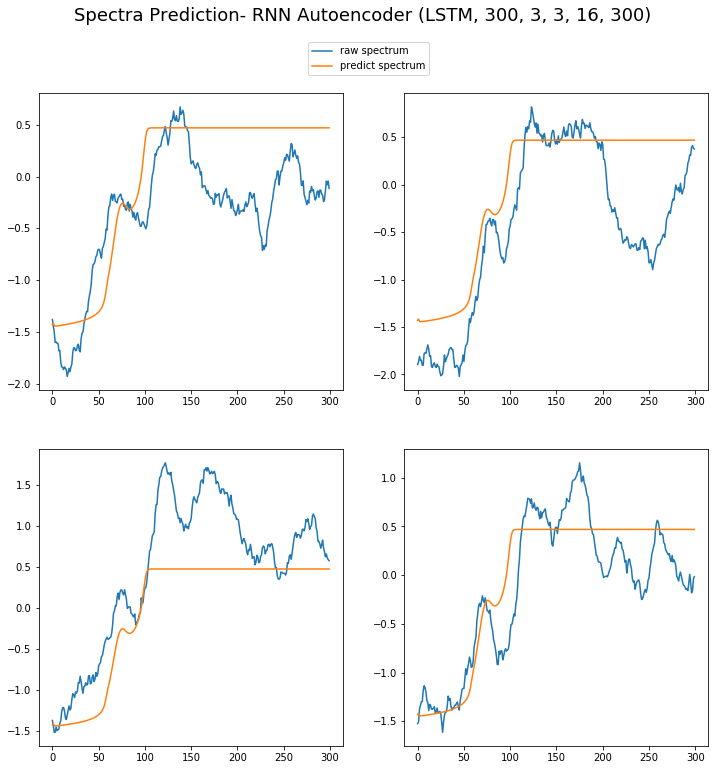

In [117]:
# Plotting Spectra Predictions (randomized for 36 spectra)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
from sklearn import preprocessing
#y1_norm = preprocessing.normalize(x_test)
#y2_norm = preprocessing.normalize(y_predict.reshape(-1,128))
y1_norm = test
y2_norm = predict.reshape(-1,300)
axs.reshape(-1)
for i in range (0,2):
    for j in range(0,2):
        w = np.random.randint(0, y2_norm.shape[0])
        ax = axs[i,j]
        ax.plot(y1_norm[w], label="raw spectrum") 
        ax.plot(y2_norm[w], label="predict spectrum") 
plt.legend(bbox_to_anchor=(.1, 2.39), bbox_transform=ax.transAxes)
fig.suptitle("Spectra Prediction- RNN Autoencoder (LSTM, 300, 3, 3, 16, 300)", fontsize=18)